# 7. User equipment side: Physical Broadcast Channel in 5G Networks
The Physical Broadcast Channel (PBCH) carries the Master Information Block (MIB). The MIB contains essential information for downlink synchronization of user equipment, such as cell identity, system bandwidth, and configurations of other channels. In this experiment, the complete implementation of the PBCH chain is discussed in detail.

## 7.2 Import Libraries
### 7.2 Import Python and SDR Libraries

In [1]:
# %matplotlib widget

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import numpy as np
import tensorflow as tf
import sionna as sn
import adi
import matplotlib.pyplot as plt


### 7.2 Import 5G Toolkit Libraries 

In [2]:

import sys
sys.path.append("../../../../")

from toolkit5G.SequenceGeneration import PSS, SSS, DMRS
from toolkit5G.PhysicalChannels   import PBCH
from toolkit5G.ResourceMapping    import SSB_Grid, ResourceMapperSSB
from toolkit5G.OFDM               import OFDMModulator
from toolkit5G.MIMOProcessing     import AnalogBeamforming
from toolkit5G.Configurations     import TimeFrequency5GParameters, GenerateValidSSBParameters
from toolkit5G.ReceiverAlgorithms import PSSDetection, SSSDetection, ChannelEstimationAndEqualizationPBCH, DMRSParameterDetection, CarrierFrequencyOffsetEstimation
from toolkit5G.OFDM               import OFDMDemodulator
from toolkit5G.PhysicalChannels   import PBCHDecoder


### 7.2 Import PBCH Components

In [3]:

from toolkit5G.PayloadGeneration import MIBGeneration
from toolkit5G.PayloadGeneration import MIBExtraction

from toolkit5G.PhysicalChannels.PBCH   import PBCHInterleaver
from toolkit5G.PhysicalChannels.PBCH   import PBCHDeInterleaver
from toolkit5G.ChannelCoder.PolarCoder import InputBitInterleaver
from toolkit5G.ChannelCoder.PolarCoder import InputBitDeInterleaver
from toolkit5G.Ratematcher.PolarCoder  import Subblock_Interleaver
from toolkit5G.Ratematcher.PolarCoder  import Subblock_DeInterleaver
from toolkit5G.Ratematcher.PolarCoder  import ChannelDeInterleaver
from toolkit5G.Ratematcher.PolarCoder  import ChannelInterleaver

from toolkit5G.Ratematcher.PolarCoder  import BitSelection
from toolkit5G.Ratematcher.PolarCoder  import BitDeSelection
from toolkit5G.ChannelCoder            import PolarEncoder5G
from toolkit5G.ChannelCoder     import PolarDecoder5G

# from ChannelCoder.PolarCoder.polarEncoder5G import InputBitDeInterleaver
from toolkit5G.Scrambler        import Scrambler
from toolkit5G.Scrambler        import DeScrambler
from toolkit5G.CRC              import CRCEncoder
from toolkit5G.CRC              import CRCDecoder
from toolkit5G.SymbolMapping    import Demapper
from toolkit5G.SymbolMapping    import Mapper


## 7.2 Emulation Configurations

In [4]:

# System Parameters
center_frequency    = 1e9     # Carrier frequency for signal transmission

# OFDM Parameters
Bandwidth           = 10*10**6 # bandwidth
fftSize             = 1024    # FFT-size for OFDM
subcarrier_spacing  = 30000   # Subcarrier spacing
numOFDMSymbols      = 14      # Number of OFDM symbols considered for emulation | 1 slot
sample_rate         = fftSize*subcarrier_spacing # sample rate required by OFDM and DAC/ADC of SDR

# Pulse Shaping
numSamplesPerSymbol = 1

# number of samples returned per call to rx()
buffer_size         = int(4*fftSize*1.2*numSamplesPerSymbol*numOFDMSymbols)


## 7.2 Time Frequency Parameters

In [5]:

nSymbolFrame= 140*int(subcarrier_spacing/15000);   # Number of OFDM symbols per frame (Its a function of subcarrier spacing)

## This class fetches valid set of 5G parameters for the system configurations 
tfParams    = TimeFrequency5GParameters(Bandwidth, subcarrier_spacing, fftsize = fftSize)
tfParams(nSymbolFrame, typeCP = "normal")
nRB         = tfParams.numRBs        # SSB Grid size (Number of RBs considered for SSB transition)
Neff        = tfParams.Neff          # Number of resource blocks for Resource Grid ( exclude gaurd band | offsets : BWP)
fftsize     = tfParams.fftsize       # FFT-size for OFDM
lengthCP    = tfParams.lengthCP      # CP length


## 7.2 SDR Setup

In [6]:

# SDR setup
sdr             = adi.Pluto("ip:192.168.2.1")       # Create object of SDR setup object and configure the IP of SDR connect to the system
sdr.sample_rate = int(sample_rate)                  # Sets the sample rate for the ADC/DAC of the SDR.

# Config Rx
sdr.rx_lo                   = int(center_frequency) # Sets the receiver local oscillator frequency. 
# For Pluto SDR, rx_lo can take a value between 325 MHz to 3.8 GHz.
sdr.rx_rf_bandwidth         = int(60*10**6)         # Set the bandwidth (in Hz) of the reception filter
# For Pluto SDR, tx_rf_bandwidth should be between 200 kHz and 56 MHz.
sdr.rx_buffer_size          = int(buffer_size)      # Number of samples to read and load into SDR buffer.
# The upper limit on the size of this buffer is defined by the DRAM size.

sdr.gain_control_mode_chan0 = 'manual'              # Defines the mode of receiver AGC.
# # AGC modes: 
#     # 1. "manual"
#     # 2. "slow_attack"
#     # 3. "fast_attack"
# The receive gain on the Pluto has a range from 0 to 74.5 dB.

sdr.rx_hardwaregain_chan0   = 40.0 # dB, increase to increase the receive gain, but be careful not to saturate the ADC
# Sets the amplification gain (dB) provided by the low noise amplifier (LNA). 
# Relevant only when `gain_control_mode_chan0` is "manual".


## 7.2 Receive Samples from SDR

In [7]:

# Clear buffer just to be safe
for i in range (0, 10):
    raw_data = sdr.rx()
# Receive samples
rx_samples = sdr.rx()


## 7.2 Time Synchronization: Coarse Tuning

**(rasterOffset, PSS-ID) (368, 0)
**(rasterOffset, PSS-ID) (368, 1)
**(rasterOffset, PSS-ID) (368, 2)


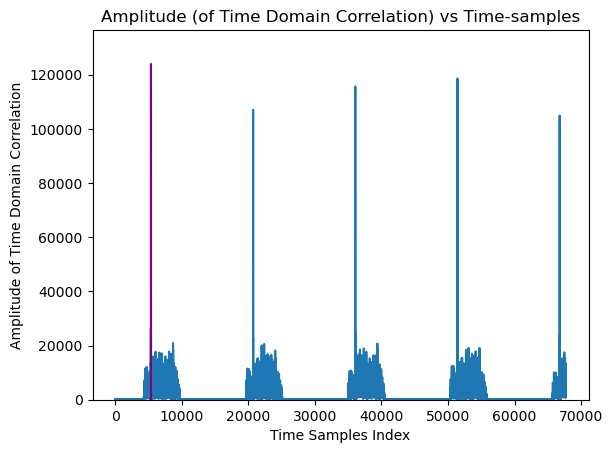

In [8]:
## PSS Detection: Based on time domain PSS Correlation

numofGuardCarriers = (int((tfParams.fftsize - Neff)/2), int((tfParams.fftsize + Neff)/2))
offsetToPointA     = 0
firstSCIndex       = int(numofGuardCarriers[0] + offsetToPointA)

## PSS Detection: Based on time domain PSS Correlation
# pssDetection   = PSSDetection("correlation", "threshold")
pssDetection   = PSSDetection("largestPeak")
ssboffset      = int(numofGuardCarriers[0]+offsetToPointA)
pssPeakIndices, pssCorrelation, rN_ID2, freqOffset = pssDetection(rx_samples, fftSize, lengthCP = lengthCP[1],
                                                                  nID2 = None, freqOffset = ssboffset)

## PSS Detection Plot
#################################################################
fig, ax = plt.subplots()

# single line
ax.plot(pssCorrelation)
ax.vlines(x = pssPeakIndices, ymin = 0*pssCorrelation[pssPeakIndices],
           ymax = pssCorrelation[pssPeakIndices], colors = 'purple')
ax.set_ylim([0,np.max(pssCorrelation)*1.1])
ax.set_xlabel("Time Samples Index")
ax.set_ylabel("Amplitude of Time Domain Correlation")
ax.set_title("Amplitude (of Time Domain Correlation) vs Time-samples")
plt.show()

## 7.2 CFO Estimation

In [9]:

## Parameters for computing CFO
cyclic_prefix_length      = lengthCP[1]  # Length of cyclic prefix
numSamples                = fftSize + cyclic_prefix_length  # OFDM samples of 1 symbol
firstIndex                = pssPeakIndices  # PSS detection
pssOfdmSymbols            = rx_samples[firstIndex: firstIndex + numSamples] # PSS samples

obj = CarrierFrequencyOffsetEstimation(fftSize,cyclic_prefix_length)
Cfo = obj(pssOfdmSymbols, numCFOIteration = 2) # Computed CFO

## 7.2 OFDM Demodulation

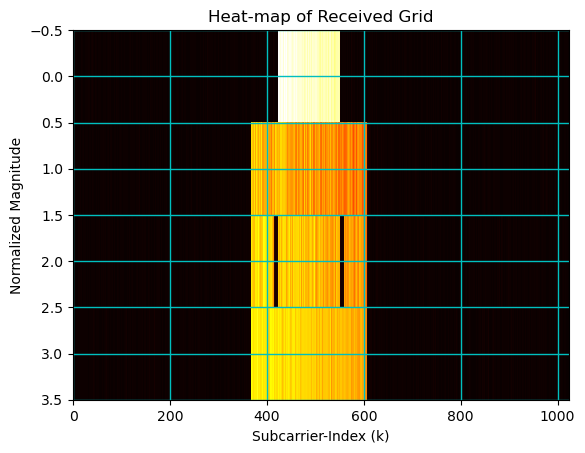

In [10]:
## OFDM Demodulator Object
ofdmDemodulator = OFDMDemodulator(fftSize, lengthCP[1])
pssStartIndex   = pssPeakIndices 
indices         = np.arange(rx_samples.size)

# Without CFO correction
cfo             = 0

# With CFO correction
cfo = Cfo

rxGrid          = ofdmDemodulator(((np.exp(-1j*cfo*indices/fftSize)*rx_samples).reshape(1,-1))[...,pssStartIndex:(pssStartIndex+4*(fftSize+lengthCP[1]))])

ssbEstimate     = rxGrid[:,:,ssboffset:(ssboffset+240)]

# Plot Received Resource Grid
fig, ax = plt.subplots()
plt.imshow(np.abs(rxGrid[0]), cmap = 'hot', interpolation='nearest', aspect = "auto")
ax = plt.gca();
ax.set_xlabel("Subcarrier-Index (k)")
ax.set_ylabel("Normalized Magnitude")
ax.set_title("Heat-map of Received Grid")
ax.grid(color='c', linestyle='-', linewidth=1)
plt.show()

## 7.2 Extract SSB Grid

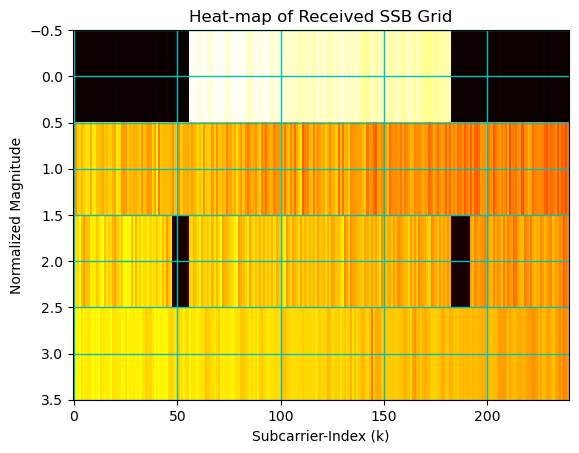

In [11]:
## Plot SSB
fig, ax = plt.subplots()
plt.imshow(np.abs(ssbEstimate[0]), cmap = 'hot', interpolation='nearest', aspect = "auto")
ax = plt.gca();
ax.grid(color='c', linestyle='-', linewidth=1)
ax.set_xlabel("Subcarrier-Index (k)")
ax.set_ylabel("Normalized Magnitude")
ax.set_title("Heat-map of Received SSB Grid")
plt.show()

## 7.2 PBCH Processing

* SSS Detection
* PBCH Parameter Estimation

In [12]:

## N_ID_1 Estimation: SSS based
sssDetection   = SSSDetection(method="channelAssisted", nID2=rN_ID2)
rN_ID1         = sssDetection(ssbEstimate[0])
rN_ID          = 3*rN_ID1 + rN_ID2    # Estimating Physical cell-ID.

## Generate SSB object to get DMRS and PBCH Indices
rxSSBobject    = SSB_Grid(rN_ID)
rxDMRSIndices  = rxSSBobject.dmrsIndices   # Indices of PBCH DMRS.

## Generate DMRS sequence
nssbCandidatesInHrf = 4
dmrsLen             = 144  # Length of DMRS sequence
dmrsDetection  = DMRSParameterDetection(int(rN_ID), nssbCandidatesInHrf)
rssbIndex, rHrfBit = dmrsDetection(ssbEstimate[0])
rxDMRSobject   = DMRS("PBCH", int(rN_ID), int(rssbIndex), nssbCandidatesInHrf, rHrfBit)
rxDMRSseq      = rxDMRSobject(dmrsLen) # DMRS sequence.


## 7.2 Channel Estimation and PBCH Symbol Equalization

In [13]:

# ## Estimating the channel at DMRS (t-f) location, interpolting for data (t-f) location and equalizing the symbols
# ## Object for Channel Estimation
chanEst        = ChannelEstimationAndEqualizationPBCH(estimatorType = "ZF", interpolatorType = "Linear", isUEmobile=True)
pbchEstimate   = chanEst(ssbEstimate[0], rxDMRSseq, rN_ID)


## 7.2 PBCH Decoding

![PBCH-Rx](PBCH-Rx.svg)

## 7.2 PBCH Receiver: Components

In [14]:
# *********************************************************************************

# ## PBCH Chain for Decoding information
# polarDecoder   = "SCL"
# symbolDemapper = "app"
# extractMIBinfo = True
# pbchDecoder    = PBCHDecoder(center_frequency, int(rN_ID), nssbCandidatesInHrf, 
#                              rssbIndex, polarDecoder, symbolDemapper)
# rxMIB, check   = pbchDecoder(pbchEstimate, 10, extractMIBinfo)

# *********************************************************************************

## PBCH Chain for Decoding information
polarDecoder   = "SCL"
symbolDemapper = "app"
extractMIBinfo = True
snr            = 10
K              = 56
N              = 512
E              = 864

demapper    = Demapper("app", "qam", 2)
bits_e      = demapper([np.complex64(pbchEstimate), np.float32(1/snr)])

deScr2      = DeScrambler("PBCH-2", rN_ID, nssbCandidatesInHrf, rssbIndex)
descr2Bits  = deScr2(bits_e)

chDIL       = ChannelDeInterleaver()
chDIL_bits  = chDIL(descr2Bits)

rmD         = BitDeSelection(K, N, E)
rmDBits     = rmD(chDIL_bits)

sbDBIL      = Subblock_DeInterleaver()
sbDBil_bits = sbDBIL(rmDBits)

decoder    = PolarDecoder5G(K, E, dec_type="SC", crcType = "CRC24C", purpose = "PBCH")
decBits    = decoder(sbDBil_bits)

pbch_IBiL  = InputBitDeInterleaver()
IBDiLBits  = pbch_IBiL(decBits)

crcDecoder      = CRCDecoder("CRC24C")
dcrcBits, check = crcDecoder(IBDiLBits)

pbchDeScr  = DeScrambler("PBCH-1", rN_ID, nssbCandidatesInHrf)
descrBits  = pbchDeScr(dcrcBits)

pbchBIL    = PBCHDeInterleaver()
dILBits    = pbchBIL(descrBits)

mibRx      = MIBExtraction(center_frequency)
mibRx(dILBits)

## 7.2 Constellation Diagram: UE

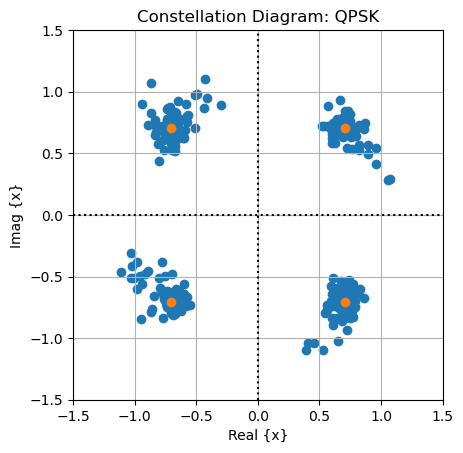

In [15]:

qpsk = np.array([1+1j, 1-1j, -1+1j, -1-1j])/np.sqrt(2)
fig, ax = plt.subplots()
ax.set_aspect(True)
ax.scatter(np.real(pbchEstimate), np.imag(pbchEstimate))
ax.scatter(np.real(qpsk), np.imag(qpsk), )
ax.grid()
ax.axhline(y=0, ls=":", c="k")
ax.axvline(x=0, ls=":", c="k")
ax.set_xlim([-1.5, 1.5])
ax.set_ylim([-1.5, 1.5])
ax.set_xlabel("Real {x}")
ax.set_ylabel("Imag {x}")
ax.set_title("Constellation Diagram: QPSK")
plt.show()


## 7.2 Checking whether CRC is correct

In [16]:
check

array([[ True]])

## 7.2 MIB and ATI Parameters at User Equioment

In [17]:
mibRx.displayParameters(0)

Carrier Frequency:	1000000000.0
ChoiceBit:  		1
nSsbCandidatesInHrf: 	4
subCarrierSpacingCommon:15000
DMRSTypeAPosition: 	typeA
controlResourceSet0:	5
searchSpace0: 		7
cellBarred: 		barred
intraFreqReselection: 	allowed
systemFrameNumber: 	367
ssbSubCarrierOffset: 	0
HRFBit: 		0
iSSBindex: 		0
